<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Функции-и-константы" data-toc-modified-id="Функции-и-константы-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Функции и константы</a></span></li><li><span><a href="#Загрузка-и-проверка-данных" data-toc-modified-id="Загрузка-и-проверка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и проверка данных</a></span></li><li><span><a href="#Сегментация" data-toc-modified-id="Сегментация-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Сегментация</a></span></li><li><span><a href="#Визуализация-сегментов" data-toc-modified-id="Визуализация-сегментов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Визуализация сегментов</a></span></li><li><span><a href="#Выводы-и-рекомендации" data-toc-modified-id="Выводы-и-рекомендации-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы и рекомендации</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from datetime import timedelta

In [2]:
#dataset settings
pd.set_option('display.max_columns', 100) #макс кол-во колонок в выводимых данных 
pd.set_option('display.max_rows', 30) #макс кол-во строк в выводимых данных
pd.set_option('display.width', 60) #макс кол-во символов в строке

#warnings and other settings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.simplefilter('ignore')
pd.options.mode.chained_assignment = None

## Функции и константы

Мы знаем перечень `client_id`, которые используются для служебных целей и не должны попадать в анализ. Укажем их в списке для того, чтобы исключить из датасета.

In [3]:
DELETE_CONTACT_ID_LIST = [7613573, 11947648, 1261434, 1264104, 11947578, 1240582,
                          1278517, 1149672, 704131, 11947525, 0]

В анализе будем использовать вот эти написанные нами функции:

In [4]:
def get_days(item: timedelta) -> int:
    """
    Функция get_days используется для извлечения количества дней из объекта item.

    Аргументы:
    item : объект datetime.timedelta
        Объект timedelta, представляющий разницу между двумя моментами 
        времени или временными интервалами.

    Возвращает:
    int
        Количество дней, представленных объектом timedelta.    
    """
    return item.days

In [5]:
def get_quantile_dict(dataframe: pd.DataFrame) -> dict: 
    """
    Функция get_quantile_dict вычисляет квантили для колонок 'recency', 'frequency', 'monetary' 
    в DataFrame и возвращает результат в виде словаря.

    Аргументы:
    dataframe : pandas.DataFrame
    DataFrame, содержащий колонки 'recency', 'frequency', 'monetary', 
    для которых нужно вычислить квантили.

    Возвращает:
    dict
    Словарь, содержащий квантили для каждой из указанных колонок. 
    Ключи словаря - это квантили (0.2, 0.4, 0.6, 0.8),
    значения - это словари с ключами 'recency', 'frequency', 'monetary' 
    и значениями квантилей соответствующих колонок.
    """
    return dataframe[['recency', 'frequency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()

In [6]:
def get_r_score(x: int) -> int:
    """
    Функция get_r_score используется для вычисления рейтинга по 
    параметру recency (недавности) на основе значений x и словаря 
    квантилей quant_dict.

    Аргументы:
    x : int
        Значение параметра recency, для которого нужно вычислить рейтинг.
    quant_dict : dict
        Словарь, содержащий квантили для параметра recency. 
        Ключи словаря - это квантили (0.2, 0.4, 0.6, 0.8), значения - это квантили для recency.

    Возвращает:
    int
        Числовой рейтинг на основе значения параметра recency
    """
    x = int(x)
    
    if x <= quant_dict['recency'][.2]:
        return 5
    elif quant_dict['recency'][.2] < x <= quant_dict['recency'][.4]:
        return 4
    elif quant_dict['recency'][.4] < x <= quant_dict['recency'][.6]:
        return 3
    elif quant_dict['recency'][.6] < x <= quant_dict['recency'][.8]:
        return 2
    elif quant_dict['recency'][.8] < x:
        return 1
    
def get_f_score(x: int) -> int:
    """
    Вычисляет рейтинг по параметру frequency на основе значения x и словаря квантилей quant_dict.

    Аргументы:
    x : int
        Значение параметра frequency, для которого нужно вычислить рейтинг.
        
    quant_dict : dict
        Словарь, содержащий квантили для параметра frequency. 
        Ключи словаря - это квантили (0.2, 0.4, 0.6, 0.8), 
        значения - это квантили для frequency.

    Возвращает:
    int
        Рейтинг, вычисленный на основе значения параметра frequency:    
    """
    x = int(x)
    
    if x <= quant_dict['frequency'][.2]:
        return 1
    elif quant_dict['frequency'][.2] < x <= quant_dict['frequency'][.4]:
        return 2
    elif quant_dict['frequency'][.4] < x <= quant_dict['frequency'][.6]:
        return 3
    elif quant_dict['frequency'][.6] < x <= quant_dict['frequency'][.8]:
        return 4
    elif quant_dict['frequency'][.8] < x:
        return 5
    
def get_m_score(x: int) -> int:
    """
    Функция вычисляет рейтинг на основе параметра monetary с учетом значения x 
    и словаря квантилей quant_dict.

    Аргументы:
    x : int
        Значение параметра monetary, для которого требуется вычислить рейтинг.
    quant_dict : dict
        Словарь, содержащий квантили для параметра monetary. 
        Ключи словаря - это квантили (0.2, 0.4, 0.6, 0.8), 
        значения - это квантили для monetary.

    Возвращает:
    int
        Рейтинг, вычисленный на основе значения параметра monetary.
    """
    x = int(x)
    
    if x <= quant_dict['monetary'][.2]:
        return 1
    elif quant_dict['monetary'][.2] < x <= quant_dict['monetary'][.4]:
        return 2
    elif quant_dict['monetary'][.4]< x <= quant_dict['monetary'][.6]:
        return 3
    elif quant_dict['monetary'][.6] < x <= quant_dict['monetary'][.8]:
        return 4
    elif quant_dict['monetary'][.8] < x:
        return 5

In [7]:
def get_rfm_macro(item: str) -> str: 
    """
    Функция возвращает макросегмент RFM на основе значения item.

    Аргументы:
    item : str
        Значение параметра RFM, для которого требуется определить макросегмент.

    Возвращает:
    str
        Макросегмент RFM, вычисленный на основе значения item.
    """
    
    macrosegment_dict = {
        '51': 'Новые', '41': 'Новые', '52': 'Активные', '53': 'Активные', 
        '54': 'Активные', '55': 'Активные', '42': 'Активные', 
        '43': 'Активные', '44': 'Активные', '45': 'Активные'
    }
    
    try:
        return macrosegment_dict[str(item)[:-1]]
    except: 
        return 'Отток'

In [8]:
def get_rfm_segment(item: int) -> str: 
    """
    Функция возвращает сегмент RFM на основе значения item.

    Аргументы:
    item : int
        Значение параметра RFM, для которого требуется определить сегмент.

    Возвращает:
    str
        Сегмент RFM, вычисленный на основе значения item.
    """
    
    item = int(item)
    if item in [525, 524, 523, 515, 514, 513, 425, 424, 423, 415, 414, 413]: 
        return 'Новички'
    elif item in [522, 521, 512, 511, 422, 421, 412, 411, 323, 322, 321, 313, 
                  312, 311, 225, 224, 223, 222, 221, 215, 214, 213, 212, 211, 
                  125, 124, 123, 122, 121, 115, 114, 113, 112, 111]: 
        return 'Случайные'
    elif item in [555, 554, 545, 544, 455, 454, 445, 444]: 
        return 'ВИП'
    elif item in [553, 543, 535, 534, 533, 453, 443, 435, 434, 433]: 
        return 'Хорошие'
    elif item in [552, 551, 542, 541, 532, 531, 452, 451, 442, 441, 432, 431]: 
        return 'Хорошие экономные'
    elif item in [355, 354, 353, 345, 344, 343, 335, 334, 333]: 
        return 'Уходящие хорошие' 
    elif item in [352, 351, 342, 341, 332, 331]: 
        return 'Уходящие экономные'
    elif item in [232, 231, 132, 131]: 
        return 'Отток экономные'
    elif item in [253, 252, 251, 243, 242, 241, 235, 234, 233, 153, 152, 151, 143, 
                  142, 141, 135, 134, 133]: 
        return 'Отток обычные'
    elif item in [325, 324,315, 314, 255, 254, 245, 244, 155, 154, 145, 144]: 
        return 'Потерянные ВИП'

In [9]:
def get_first_date_of_month(dt: datetime) -> datetime:
    """
    Функция возвращает первый день месяца на основе переданной даты.

    Аргументы:
    dt : datetime
        Исходная дата, для которой требуется определить первый день месяца.

    Возвращает:
    datetime
        Первый день месяца, вычисленный на основе переданной даты.
        """
    return datetime(dt.year, dt.month, 1)

In [10]:
def get_rfm_plot(rfm_base: pd.DataFrame) -> None:
    """
    Функция строит графики для распределения клиентов по R и F и по M для каждой комбинации F и R.

    Аргументы:
    rfm_base : DataFrame
        DataFrame, содержащий данные для анализа

    Возвращает:
    None
        Функция отображает графики, но не возвращает значения.

    Примечания:
    Функция строит два графика: первый для распределения клиентов по R и F, 
    второй - для распределения M для каждой комбинации F и R.
    """
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    
    for i, p in enumerate(['R', 'F']):
        
        parameters = {'R':'recency', 'F':'frequency'}
        
        y = rfm_base[p].value_counts().sort_index()
        x = y.index
        
        ax = axes[i]
        bars = ax.bar(x, y, color='silver')
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        
        ax.set_title('Distribution of {}'.format(parameters[p]), fontsize=14)
        
        for bar in bars:
            value = bar.get_height()
            
            if value == y.max():
                bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
                ha='center',
                va='top',
                color='w')
    plt.show()

    # plot the distribution of M for RF score
    fig, axes = plt.subplots(nrows=5, ncols=5,
                             sharex=False, sharey=True,
                             figsize=(10, 10))

    r_range = range(1, 6)
    f_range = range(1, 6)

    for r in r_range:
        for f in f_range:
            y = rfm_base[(rfm_base['R'] == r) & (rfm_base['F'] == f)]['M'].value_counts().sort_index()
            x = y.index
            ax = axes[r - 1, f - 1]
            bars = ax.bar(x, y, color='silver')
            if r == 5:
                if f == 3:
                    ax.set_xlabel('{}\nF'.format(f), va='top')
                else:
                    ax.set_xlabel('{}\n'.format(f), va='top')
            if f == 1:
                if r == 3:
                    ax.set_ylabel('R\n{}'.format(r))
                else:
                    ax.set_ylabel(r)
            ax.set_frame_on(False)
            ax.tick_params(left=False, labelleft=False, bottom=False)
            ax.set_xticks(x)
            ax.set_xticklabels(x, fontsize=8)

            for bar in bars:
                value = bar.get_height()
                if value == y.max():
                    bar.set_color('firebrick')
                ax.text(bar.get_x() + bar.get_width() / 2,
                        value,
                        int(value),
                        ha='center',
                        va='bottom',
                        color='k')
            
    fig.suptitle('Distribution of M for each F and R', fontsize=14)
    
    plt.tight_layout()
    
    plt.show()

In [11]:
def get_segment_barchart(rfm_base: pd.DataFrame) -> None:
    # count the number of customers in each segment
    """
    Функция строит столбчатую диаграмму для подсчета количества клиентов в каждом сегменте.

    Аргументы:
    rfm_base : DataFrame
        DataFrame, содержащий данные для анализа

    Возвращает:
    None
        Функция отображает столбчатую диаграмму, но не возвращает значения.

    Примечания:
    Функция подсчитывает количество клиентов в каждом сегменте на основе данных 
    из столбца 'rfm_segment' датафрейма rfm_base и строит столбчатую диаграмму, 
    отображая распределение клиентов по сегментам.
    """
    segments_counts = rfm_base['segment'].value_counts().sort_values(ascending=True)

    fig, ax = plt.subplots()

    bars = ax.barh(range(len(segments_counts)),
                  segments_counts,
                  color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False,
                   bottom=False,
                   labelbottom=False)
    ax.set_yticks(range(len(segments_counts)))
    ax.set_yticklabels(segments_counts.index)

    for i, bar in enumerate(bars):
            value = bar.get_width()
            if segments_counts.index[i] in ['Активные.ВИП', 'Активные.Хорошие']:
                bar.set_color('firebrick')
            ax.text(value,
                    bar.get_y() + bar.get_height()/2,
                    '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                    va='center',
                    ha='left'
                   )

    plt.show()

## Загрузка и проверка данных

In [12]:
df = pd.read_excel('total_sales.xlsx')[['contact_id', 'date_time', 'cheq_id', 'cheq_sum']]
df.head()

,contact_id,date_time,cheq_id,cheq_sum
0,692705,2023-11-09 18:33:12,-9223372036610950144,2725.0
1,17324395,2023-08-11 18:54:35,-9223372036646039552,8625.0
2,18625184,2024-01-06 00:31:27,-9223372036587329536,1440.0
3,1478822,2023-10-22 20:01:11,-9223372036616890368,4040.0
4,768915,2023-08-16 22:39:16,-9223372036643269632,3000.0


In [13]:
df.isna().sum()

contact_id    0
date_time     0
cheq_id       0
cheq_sum      0
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498003 entries, 0 to 498002
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   contact_id  498003 non-null  int64         
 1   date_time   498003 non-null  datetime64[ns]
 2   cheq_id     498003 non-null  int64         
 3   cheq_sum    498003 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 15.2 MB


Дата сегментации – последний день прошедшего календарного месяца.

In [15]:
end_of_period = get_first_date_of_month(max(df['date_time']))
end_of_period

datetime.datetime(2024, 1, 1, 0, 0)

Окно сегментации – 9 месяцев – это рассматриваемый период покупательской активности. При выгрузке данных из `Clickhouse` мы это учитывали.

- `Recency` - количество дней с момента последней покупки до того дня, на который строится сегментация. 
- `Frequency` - количество чеков за период (окно сегментации). 
- `Monetary` - общая сумма чеков за период (окно сегментации).

In [16]:
df = df.loc[df['date_time'] < end_of_period]
df = df.loc[df['contact_id'].apply(lambda x: x not in DELETE_CONTACT_ID_LIST)]

In [17]:
df['recency'] = (end_of_period - df['date_time']).apply(get_days)

In [18]:
rfm_base = df.groupby(['contact_id']).agg(
    {'recency': 'min', 'cheq_id': 'count', 'cheq_sum': 'sum'}).reset_index()

In [19]:
rfm_base.columns=['contact_id', 'recency', 'frequency', 'monetary']

In [20]:
rfm_base.head()

,contact_id,recency,frequency,monetary
0,472800,38,4,8903.0
1,472802,126,1,3770.0
2,472807,9,9,14597.5
3,472808,42,3,9520.0
4,472810,110,1,490.0


## Сегментация

Создадим словарь для квантилей по каждому из измерений.

In [21]:
quant_dict = get_quantile_dict(rfm_base)
quant_dict

{'recency': {0.2: 22.0, 0.4: 56.0, 0.6: 100.0, 0.8: 164.0},
 'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 2.0, 0.8: 3.0},
 'monetary': {0.2: 1804.0, 0.4: 3025.0, 0.6: 5105.0, 0.8: 9658.0}}

С использованием функций присвоим код по каждому измерению. 

In [22]:
rfm_base['R'] = rfm_base['recency'].apply(get_r_score)
rfm_base['F'] = rfm_base['frequency'].apply(get_f_score)
rfm_base['M'] = rfm_base['monetary'].apply(get_m_score)

rfm_base['RFM'] = rfm_base['R'].astype(str) + rfm_base['F'].astype(str) + rfm_base['M'].astype(str)

rfm_base['rfm_macrosegment'] = rfm_base['RFM'].apply(get_rfm_macro)
rfm_base['rfm_segment'] = rfm_base['RFM'].apply(get_rfm_segment)

In [23]:
rfm_base['segment'] = rfm_base['rfm_macrosegment'] + '.' + rfm_base['rfm_segment']

In [24]:
rfm_base['segment'].value_counts()

Отток.Случайные               61627
Активные.ВИП                  28152
Отток.Уходящие хорошие        14573
Новые.Случайные               14306
Активные.Хорошие              13859
Отток.Отток обычные           10755
Отток.Потерянные ВИП           7962
Новые.Новички                  7600
Активные.Хорошие экономные     3592
Отток.Отток экономные          3305
Отток.Уходящие экономные       2320
Name: segment, dtype: int64

## Визуализация сегментов

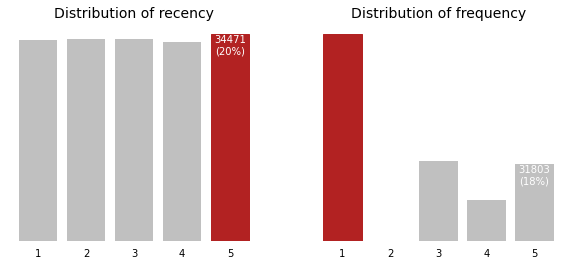

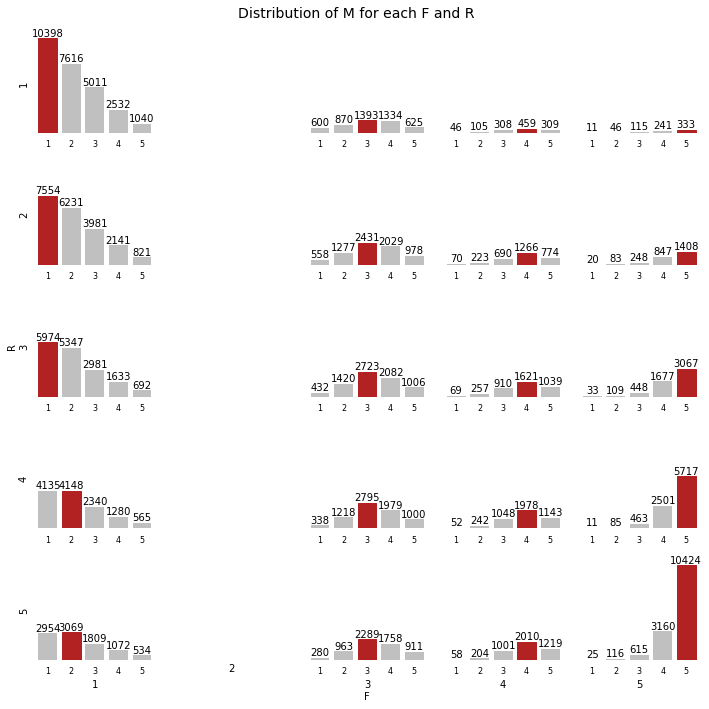

In [25]:
get_rfm_plot(rfm_base)

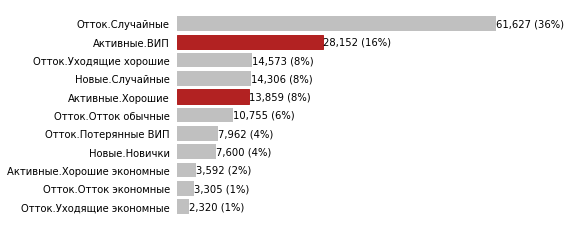

In [26]:
get_segment_barchart(rfm_base)

## Выводы и рекомендации

__Отток.Случайные__

- составляют треть клиентской базы в нашем случае, что плохо
- в этом сегменте находятся клиенты, которые делали заказы разово и более не возвращались

Рекомендуется делать предложения для стимулирования повторного заказа, например, скидки или подарки к заказу, чтобы заинтересовать их вернуться и стать постоянными. 

__Активные.ВИП, Активные.Хорошие__

- составляют четверть клиентской базы в нашем случае

`Активные.ВИП` - наиболее ценные клиенты, которые делают частые и крупные заказы.
- Рекомендации: индивидуальные бонусы, персонализированные предложения, участие в эксклюзивных программах лояльности или VIP-мероприятия. 
- Цель: стимулировать их частые посещения и увеличение среднего чека.

`Активные.Хорошие` - также активный, но их заказы меньше по сравнению с ВИП-клиентами. 
- Рекомендуется предлагать им индивидуальные условия программы лояльности, например, бонусы за накопленные заказы, купоны на скидку или предложения "купи больше, получи больше". 
- Цель - увеличить средний чек и удерживать клиентов в этом сегменте.

__Новые.Новички и Новые.Случайные__

`Новые.Новички` - это новые клиенты, которые только начали пользоваться услугами ресторана. 
- Рекомендуется привлекать их специальными предложениями для первого заказа, например, скидки на первый заказ или подарки к заказу. 
- Цель - заинтересовать их и превратить в постоянных клиентов.

`Новые.Случайные` - сегмент также состоит из новых клиентов, но склонных к случайным заказам. 
- Рекомедуется делать им привлекательные предложения для повторной покупки, чтобы удержать их. 
- Цель - превратить случайных клиентов в постоянных.

__Активные.Хорошие экономные__

- Этот сегмент чувствителен к цене, поэтому следует делать им экономичные предложения, специальные акции и скидки на более дешевые позиции в меню, а также на комбо-наборы. 
- Цель - увеличить их частоту заказов и удерживать их в качестве постоянных клиентов.

__Отток__

`Отток.Отток обычные` - этот сегмент включает клиентов, которые раньше были активными, но перестали делать заказы. 
- Следует провести персонализированную рекламную кампанию, направленную на возвращение клиентов. 
- Это может включать специальные акции, скидки для повторных заказов и напоминания о преимуществах заказа в ресторане.

`Отток.Отток экономные` - в этом сегменте находятся клиенты, которые ушли из-за ценовых причин. 
- Стоит предложить им специальные предложения и скидки, которые позволят клиентам сэкономить при следующем заказе. 

`Отток.Потерянные ВИП` - этот сегмент включает клиентов, которые раньше были наиболее ценными, но перестали делать заказы. 
- Рекомендуется внедрить специальную программу для этих клиентов, включая персонализированные предложения, приглашения на эксклюзивные мероприятия и бонусы за возвращение.

`Отток.Отток Случайные` - в этом сегменте находятся клиенты, которые делали заказы разово и более не возвращались. 
- Рекомендуется делать предложения для стимулирования повторного заказа, например, скидки или подарки к заказу, чтобы заинтересовать их вернуться и стать постоянными. 

`Отток.Уходящие хорошие` - этот сегмент включает клиентов, которые раньше были активными и приносили хороший доход, но сейчас показывают признаки ухода. 
- Рекомендуется провести дополнительный анализ и понять, что могло спровоцировать уход клиентов данного сегмента. 
- После этого можно предложить индивидуальные бонусы, персонализированные предложения, чтобы возвратить и удержать их.

`Отток.Уходящие эконом` - в этом сегменте находятся клиенты, которые раньше были склонны к экономии, но сейчас показывают признаки ухода. 
- Стоит протестировать cпециальные акции и скидки, чтобы заинтересовать клиентов из этого сегмента вернуться.